**Aim** : Implement an end to end project for image classification

**Dataset** : Rock Paper Scissors (Source http://www.laurencemoroney.com/rock-paper-scissors-dataset/)

Each image is 300×300 pixels in 24-bit color.

There are 2520 examples examples in the training set, 840 per class.
The validation set contains 372 examples (124 per class).
The test set contains 9 unlabeled images per class.

**Broad Methodology** :

Load the dataset

Augment & Split the dataset inti training, validation and test data

Define the Model for classification

Train & evaluate the predictions


Data loading using zipfile

In [1]:
import zipfile

In [2]:
zip_path = "/home/deepaksr/project/project_assignment1/rps.zip"
folder_path = "/home/deepaksr/project/project_assignment1/data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)
    
print(f"Data extracted to {folder_path}")

Data extracted to /home/deepaksr/project/project_assignment1/data


Data Verification

In [1]:
import os

In [2]:
train_path='/home/deepaksr/project/project_assignment1/data/train'
valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data/test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
print('Validation Data:')
verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: paper
Images: 840

class: scissors
Images: 840

class: rock
Images: 840

Validation Data:
class: paper
Images: 124

class: scissors
Images: 124

class: rock
Images: 124

Test Data:
class: paper
Images: 11

class: scissors
Images: 11

class: rock
Images: 11



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

2024-08-31 22:30:39.773937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 22:30:39.795204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 22:30:39.801692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 22:30:39.817905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-31 22:30:40.733040: W tensorflow/comp

In [4]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=35,
                                            shuffle=True)
val_generator = datagen.flow_from_directory(directory=valid_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=31,
                                            shuffle=True)
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=33,
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
{'paper': 0, 'rock': 1, 'scissors': 2}
2520
{'paper': 0, 'rock': 1, 'scissors': 2}
372
{'paper': 0, 'rock': 1, 'scissors': 2}
33


Checking Shape of loaded data batches

In [7]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (35, 300, 300, 3), Labels shape: (35, 3)
Validation batch shape: (31, 300, 300, 3), Labels shape: (31, 3)
Test batch shape: (33, 300, 300, 3), Labels shape: (33, 3)


Define the CNN using keras.models & keras.layers

In [5]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [15]:
def get_model():
  net = Sequential()
  net.add(Conv2D(32,(3,3), activation = 'relu', padding='same', input_shape=(300,300,3)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  net.add(Dense(512, activation='relu'))
  net.add(Dense(256, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [16]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-31 22:05:54.360472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2024-08-31 22:05:54.361286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9798 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-08-31 22:05:54.362026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 720000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   368,640,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,810,499 (1.37 GB)

 Trainable params: 368,810,499 (1.37 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
plot_model(model, 'cnn.jpg', show_shapes=True,show_layer_names=True)

Training the Model: 25 Epochs 

In [19]:
history = model.fit(train_generator, validation_data=val_generator, epochs=25)

Epoch 1/25


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725122255.463274 2113895 service.cc:146] XLA service 0x7fa53800bd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725122255.463364 2113895 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725122255.463387 2113895 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725122255.463400 2113895 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725122255.463414 211

 1/72 ━━━━━━━━━━━━━━━━━━━━ 17:05 14s/step - accuracy: 0.3714 - loss: 1.0932

I0000 00:00:1725122261.661967 2113895 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 65s 712ms/step - accuracy: 0.4455 - loss: 12.7902 - val_accuracy: 0.6478 - val_loss: 0.7103
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 658ms/step - accuracy: 0.9080 - loss: 0.3185 - val_accuracy: 0.7769 - val_loss: 0.6208
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 652ms/step - accuracy: 0.9677 - loss: 0.0982 - val_accuracy: 0.8038 - val_loss: 0.6575
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 657ms/step - accuracy: 0.9871 - loss: 0.0459 - val_accuracy: 0.8387 - val_loss: 0.4431
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 657ms/step - accuracy: 0.9495 - loss: 0.1739 - val_accuracy: 0.8253 - val_loss: 1.0723
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 652ms/step - accuracy: 0.9811 - loss: 0.0517 - val_accuracy: 0.8522 - val_loss: 0.7905
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 670ms/step - accuracy: 0.9979 - loss: 0.0099 - val_accuracy: 0.8522 - val_loss: 0.9552
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 656ms/step - accuracy: 0.9923 - loss: 0.0173 - val_accuracy: 0.84

In [ ]:
history_dict = history.history

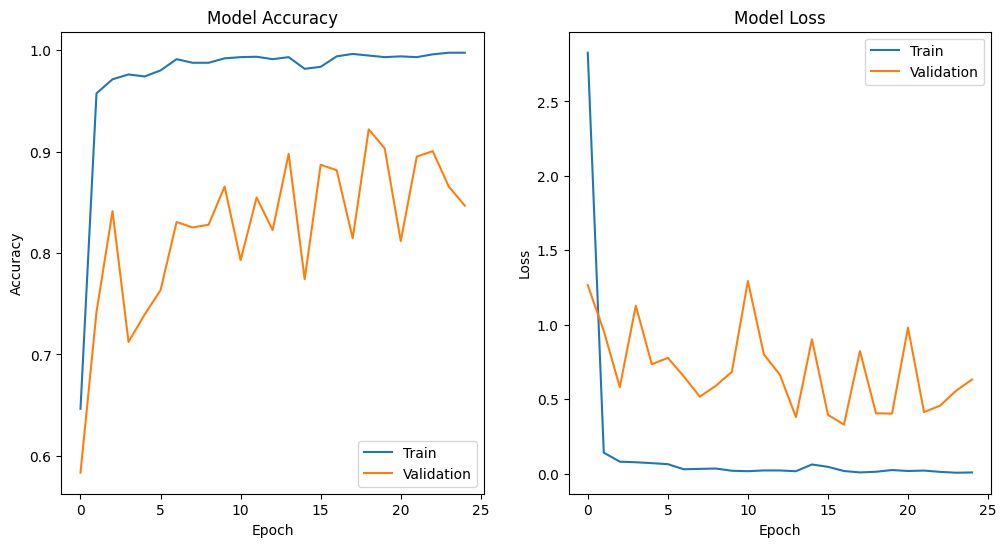

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [12]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [13]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9091
Precision : 0.9286
Recall : 0.9091
F1 Score : 0.9074
Classification Report:
               precision    recall  f1-score   support

       paper       0.79      1.00      0.88        11
        rock       1.00      1.00      1.00        11
    scissors       1.00      0.73      0.84        11

    accuracy                           0.91        33
   macro avg       0.93      0.91      0.91        33
weighted avg       0.93      0.91      0.91        33



In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[11  0  0]
 [ 0 11  0]
 [ 3  0  8]]


Training & Evaluating the same CNN again

In [13]:
history = model.fit(train_generator, validation_data=val_generator, epochs=25)

Epoch 1/25


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725015066.429478 1882703 service.cc:146] XLA service 0x7f0f58005450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725015066.429578 1882703 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725015066.429590 1882703 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725015066.429603 1882703 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725015066.429647 188

 2/72 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.2714 - loss: 66.3329

I0000 00:00:1725015072.777349 1882703 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 705ms/step - accuracy: 0.3781 - loss: 21.2873 - val_accuracy: 0.6263 - val_loss: 0.8379
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 662ms/step - accuracy: 0.8221 - loss: 0.4539 - val_accuracy: 0.7446 - val_loss: 0.7553
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 659ms/step - accuracy: 0.9475 - loss: 0.1742 - val_accuracy: 0.7769 - val_loss: 0.6439
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 656ms/step - accuracy: 0.9711 - loss: 0.0878 - val_accuracy: 0.8441 - val_loss: 0.5401
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 667ms/step - accuracy: 0.9535 - loss: 0.1266 - val_accuracy: 0.7312 - val_loss: 0.8741
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 652ms/step - accuracy: 0.9716 - loss: 0.0819 - val_accuracy: 0.7796 - val_loss: 0.9849
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 658ms/step - accuracy: 0.9750 - loss: 0.0674 - val_accuracy: 0.8226 - val_loss: 0.5800
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 651ms/step - accuracy: 0.9783 - loss: 0.0622 - val_accuracy: 0.92

In [20]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[0 0 0 0 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2 2 2 2 2 2 2 0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [22]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.8788
Precision : 0.8860
Recall : 0.8788
F1 Score : 0.8778
Classification Report:
               precision    recall  f1-score   support

       paper       0.77      0.91      0.83        11
        rock       1.00      1.00      1.00        11
    scissors       0.89      0.73      0.80        11

    accuracy                           0.88        33
   macro avg       0.89      0.88      0.88        33
weighted avg       0.89      0.88      0.88        33



CNN with different Architecture

In [9]:
def get_CNN():
  net=Sequential()
  net.add(Conv2D(32,(5,5),activation='relu', input_shape=(300,300,3)))
  net.add(MaxPooling2D(2,2))
  net.add(Conv2D(64,(3,3), activation='relu'))
  net.add(MaxPooling2D(2,2))
  net.add(Conv2D(128,(3,3), activation='relu'))
  net.add(MaxPooling2D(2,2))
  net.add(Conv2D(256,(3,3), activation='relu'))
  net.add(MaxPooling2D(2,2))
  net.add(Dropout(0.25))
  net.add(Conv2D(512,(3,3), activation='relu'))
  net.add(MaxPooling2D(2,2))
  net.add(Flatten())
  net.add(Dense(512, activation='relu'))
  net.add(Dense(128, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

In [10]:
model=get_CNN()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-31 22:33:02.795551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2024-08-31 22:33:02.796570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9798 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-08-31 22:33:02.797351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 296, 296, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,481,731 (55.24 MB)

 Trainable params: 14,481,731 (55.24 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(train_generator, validation_data=val_generator, epochs=25)

Epoch 1/25


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725123843.859296 2120429 service.cc:146] XLA service 0x7f65c8012a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725123843.859388 2120429 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725123843.859405 2120429 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725123843.859422 2120429 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1725123843.859435 212

 1/72 ━━━━━━━━━━━━━━━━━━━━ 15:44 13s/step - accuracy: 0.3143 - loss: 1.0972

I0000 00:00:1725123849.792249 2120429 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 708ms/step - accuracy: 0.3550 - loss: 1.1467 - val_accuracy: 0.7446 - val_loss: 0.8566
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 647ms/step - accuracy: 0.7897 - loss: 0.5133 - val_accuracy: 0.7339 - val_loss: 0.6696
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 658ms/step - accuracy: 0.9363 - loss: 0.2058 - val_accuracy: 0.8844 - val_loss: 0.3172
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 655ms/step - accuracy: 0.9599 - loss: 0.1122 - val_accuracy: 0.8441 - val_loss: 0.4940
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 647ms/step - accuracy: 0.9850 - loss: 0.0485 - val_accuracy: 0.8548 - val_loss: 0.4247
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 685ms/step - accuracy: 0.9776 - loss: 0.0555 - val_accuracy: 0.8925 - val_loss: 0.2887
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 667ms/step - accuracy: 0.9906 - loss: 0.0254 - val_accuracy: 0.8952 - val_loss: 0.2988
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 654ms/step - accuracy: 0.9903 - loss: 0.0369 - val_accuracy: 0.825

In [12]:
history_dict = history.history

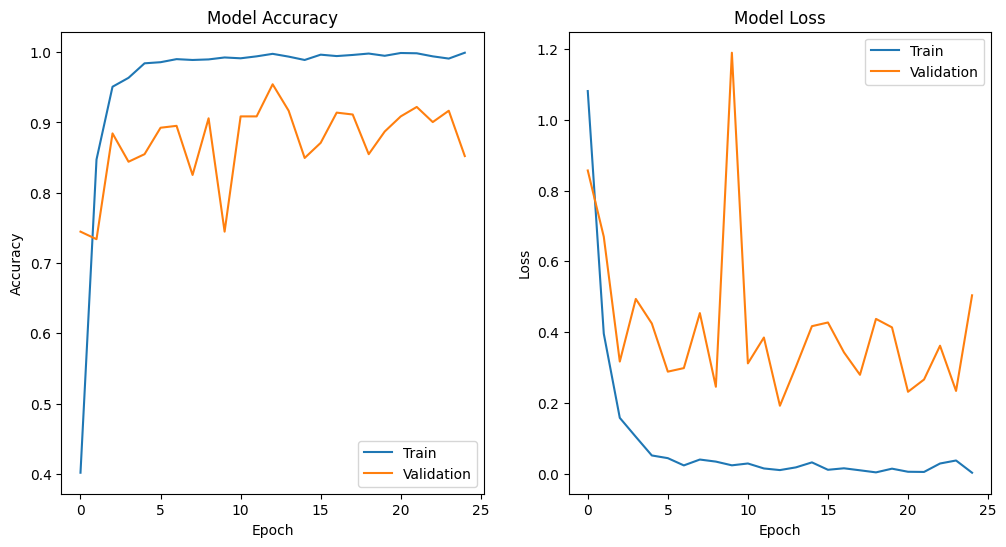

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [14]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0 0 0 0 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 2 2 2 2 1 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [15]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9091
Precision : 0.9086
Recall : 0.9091
F1 Score : 0.9076
Classification Report:
               precision    recall  f1-score   support

       paper       0.91      0.91      0.91        11
        rock       0.92      1.00      0.96        11
    scissors       0.90      0.82      0.86        11

    accuracy                           0.91        33
   macro avg       0.91      0.91      0.91        33
weighted avg       0.91      0.91      0.91        33



In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[10  0  1]
 [ 0 11  0]
 [ 1  1  9]]


Define the CNN using MobileNet Backbone

In [19]:
from tensorflow.keras.applications import MobileNet # type: ignore
from tensorflow.keras.models import Model # type: ignore # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load MobileNet pretrained model
    conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(3, activation='softmax')(top_model)
    
    # Final model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_mobilenet((300,300,3), 3, optimizer=Adam(), fine_tune=15)

# Print model summary
model.summary()


/tmp/ipykernel_2119761/4019930290.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 150, 150, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 150, 150, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 151, 151, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 75, 75, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 75, 75, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 75, 75, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 75, 75, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 45,698,243 (174.32 MB)

 Trainable params: 44,064,259 (168.09 MB)

 Non-trainable params: 1,633,984 (6.23 MB)

In [20]:
history = model.fit(train_generator, validation_data=val_generator, epochs=25)

Epoch 1/25


E0000 00:00:1725126245.018254 2120425 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725126245.176030 2120425 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725126246.718849 2120425 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725126246.844166 2120425 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8345 - loss: 12.5124

E0000 00:00:1725126293.467814 2120427 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725126293.620983 2120427 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 720ms/step - accuracy: 0.8377 - loss: 12.2747 - val_accuracy: 0.8118 - val_loss: 14.3100
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 655ms/step - accuracy: 0.9937 - loss: 0.2752 - val_accuracy: 0.4462 - val_loss: 100.2228
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 664ms/step - accuracy: 0.9982 - loss: 0.0735 - val_accuracy: 0.9489 - val_loss: 3.1241
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 652ms/step - accuracy: 0.9942 - loss: 0.5555 - val_accuracy: 0.9758 - val_loss: 0.8165
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 634ms/step - accuracy: 0.9985 - loss: 0.2131 - val_accuracy: 0.9624 - val_loss: 2.2826
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 641ms/step - accuracy: 0.9923 - loss: 0.8960 - val_accuracy: 0.7446 - val_loss: 40.7822
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 637ms/step - accuracy: 0.9999 - loss: 0.0063 - val_accuracy: 0.9543 - val_loss: 5.2133
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 657ms/step - accuracy: 0.9984 - loss: 0.0759 - val_accuracy: 

In [21]:
history_dict = history.history

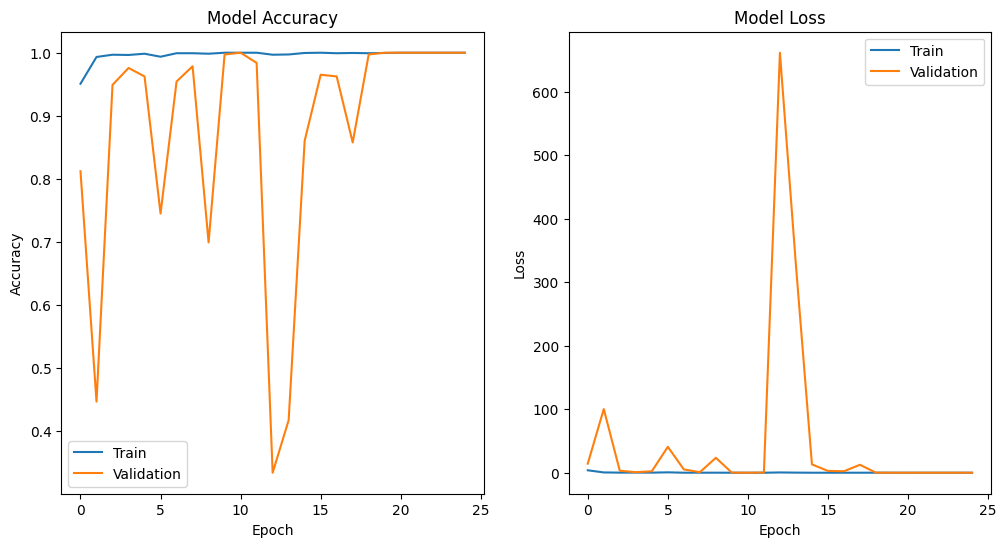

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [23]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

E0000 00:00:1725127527.271785 2120425 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725127527.429426 2120425 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [24]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 1.0000
Precision : 1.0000
Recall : 1.0000
F1 Score : 1.0000
Classification Report:
               precision    recall  f1-score   support

       paper       1.00      1.00      1.00        11
        rock       1.00      1.00      1.00        11
    scissors       1.00      1.00      1.00        11

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[11  0  0]
 [ 0 11  0]
 [ 0  0 11]]


Define the CNN using VGG16 Backbone

In [30]:
from keras.applications.vgg16 import VGG16, preprocess_input # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_VGG(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load VGG16 pretrained model
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(3, activation='softmax')(top_model)
    
    # Final model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_VGG((300,300,3), 3, optimizer=Adam(learning_rate=0.0001), fine_tune=15)

# Print model summary
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,950,403 (137.14 MB)

 Trainable params: 35,911,683 (136.99 MB)

 Non-trainable params: 38,720 (151.25 KB)

In [31]:
history = model.fit(train_generator, validation_data=val_generator, epochs=25)

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 61s 700ms/step - accuracy: 0.8292 - loss: 0.4343 - val_accuracy: 0.9785 - val_loss: 0.0543
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 679ms/step - accuracy: 1.0000 - loss: 7.3609e-04 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 670ms/step - accuracy: 1.0000 - loss: 1.0709e-04 - val_accuracy: 0.9946 - val_loss: 0.0236
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 673ms/step - accuracy: 1.0000 - loss: 3.8113e-05 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 1.0000 - loss: 2.5618e-05 - val_accuracy: 0.9946 - val_loss: 0.0189
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 693ms/step - accuracy: 1.0000 - loss: 9.1578e-06 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 691ms/step - accuracy: 1.0000 - loss: 2.8919e-05 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 682ms/step - accuracy: 1.0000 -

In [32]:
history_dict = history.history

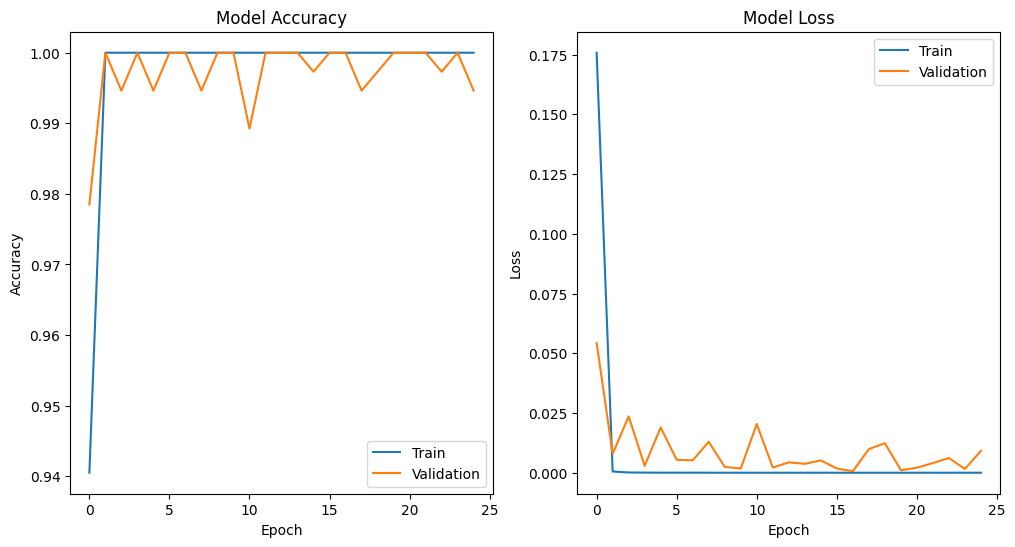

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [34]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [35]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 1.0000
Precision : 1.0000
Recall : 1.0000
F1 Score : 1.0000
Classification Report:
               precision    recall  f1-score   support

       paper       1.00      1.00      1.00        11
        rock       1.00      1.00      1.00        11
    scissors       1.00      1.00      1.00        11

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[11  0  0]
 [ 0 11  0]
 [ 0  0 11]]


Classification using Pre-Trained RESNET 50

In [37]:
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_resnet_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load ResNet50 pretrained model
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze base model layers
    if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False

    # Adding custom layers on top
    x = base_model.output
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)  
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_resnet_model((300, 300, 3), 3, optimizer=Adam(), fine_tune=15)

# Print model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 306, 306,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_3_c

 Total params: 128,447,363 (489.99 MB)

 Trainable params: 110,380,035 (421.07 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

In [38]:
history = model.fit(train_generator, validation_data=val_generator, epochs=25)

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 743ms/step - accuracy: 0.5423 - loss: 20.0696 - val_accuracy: 0.7070 - val_loss: 0.5544
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 668ms/step - accuracy: 0.9541 - loss: 0.1326 - val_accuracy: 0.8333 - val_loss: 0.4204
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 663ms/step - accuracy: 0.9786 - loss: 0.0800 - val_accuracy: 0.8548 - val_loss: 0.4332
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 647ms/step - accuracy: 0.9863 - loss: 0.0419 - val_accuracy: 0.8548 - val_loss: 0.4234
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 659ms/step - accuracy: 0.9653 - loss: 0.1030 - val_accuracy: 0.7608 - val_loss: 1.3808
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 657ms/step - accuracy: 0.9848 - loss: 0.0431 - val_accuracy: 0.7419 - val_loss: 0.9204
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 647ms/step - accuracy: 0.9869 - loss: 0.0461 - val_accuracy: 0.7527 - val_loss: 1.2953
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 663ms/step - accuracy: 0.9789 - loss: 0.0603 - val_acc

In [39]:
history_dict = history.history

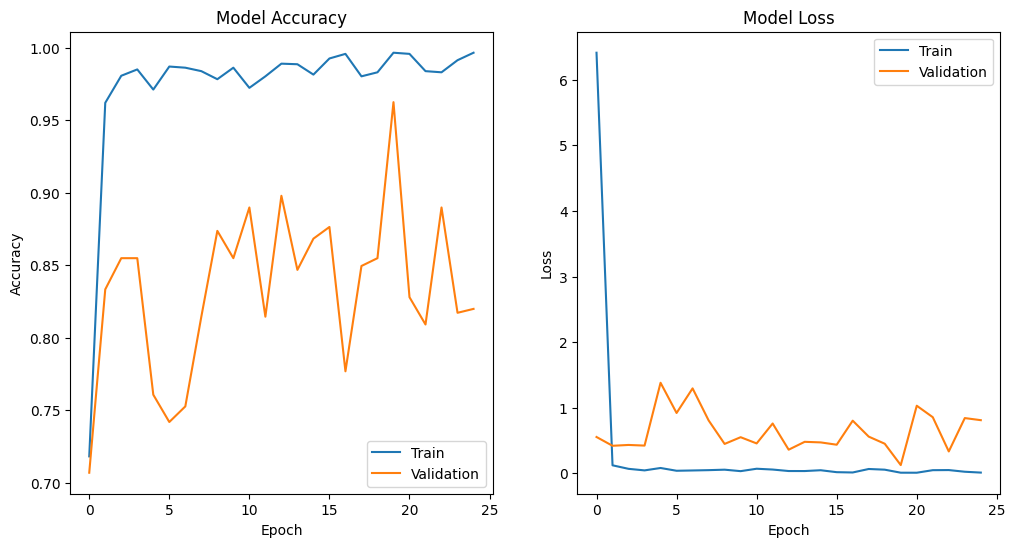

In [40]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [41]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[0 0 0 0 0 0 2 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [42]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9394
Precision : 0.9487
Recall : 0.9394
F1 Score : 0.9389
Classification Report:
               precision    recall  f1-score   support

       paper       1.00      0.82      0.90        11
        rock       1.00      1.00      1.00        11
    scissors       0.85      1.00      0.92        11

    accuracy                           0.94        33
   macro avg       0.95      0.94      0.94        33
weighted avg       0.95      0.94      0.94        33



In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 9  0  2]
 [ 0 11  0]
 [ 0  0 11]]
